In [1]:
import os
import csv
import numpy as np
from collections import namedtuple, Counter
import shutil
import cv2
import imageio
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.pyplot import imread, imshow, subplots, show
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Read in data/ProstateX-Findings-withlabel.csv to label with zone and ClinSig
csv_info = []

with open('data/ProstateX-Findings-withlabel.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=",", quotechar='"')
    _ = next(reader)
    for row in reader:
        patient, fid, pos, zone , clinsig = row
        patient = patient.split('-')[-1]
        csv_info.append((patient, fid, zone, clinsig))

print(len(csv_info))

330


In [7]:
# Load preprocessed data from lesions_cropped/t2_npy and lesions_cropped/adc_npy, ressizing to 32 by 32 arrays
# Place into pairs of t2 and adc images with their respective filenames and original side length

lesions = []
patient_list = []

NamedLesion = namedtuple('NamedLesion', 'patient t2_image t2_size adc_image adc_size fid zone clinsig') 
t2_cropped = sorted(os.listdir('data_preprocessed/t2_npy'))
adc_cropped = sorted(os.listdir('data_preprocessed/adc_npy'))
if len(t2_cropped) != len(adc_cropped):
    raise ValueError("Different numbers of images: {} T2 and {} ADC".format(len(t2_cropped), len(adc_cropped)))
input_size = len(t2_cropped)

def find_in_csv(patient, fid):
    if fid == 'Unnamed':
        fid = '1'
    for row in csv_info:
        if row[0]==patient and row[1]==fid:
            return (row[2], row[3]) #zone, clinsig

for i in range(input_size):
    t2_filename = 'data_preprocessed/t2_npy/' + t2_cropped[i]
    t2_array = np.load(t2_filename, allow_pickle=True)
    t2_img = Image.fromarray(t2_array.astype('uint8'))
    t2_img_resized = t2_img.resize((32, 32))
    t2_array_final = np.asarray(t2_img_resized)
    t2_root, _ = os.path.splitext(t2_filename)
    t2_patient, _, t2_fid = t2_root.split('/')[-1].split('+')
    t2_patient = t2_patient[-4:]
    
    adc_filename = 'data_preprocessed/adc_npy/' + adc_cropped[i]
    adc_array = np.load(adc_filename, allow_pickle=True)
    adc_img = Image.fromarray(adc_array.astype('uint8'))
    adc_img_resized = adc_img.resize((32, 32))
    adc_array_final = np.asarray(adc_img_resized)
    adc_root, _ = os.path.splitext(adc_filename)
    adc_patient, _, adc_fid = adc_root.split('/')[-1].split('+')
    adc_patient = adc_patient[-4:]
    
    if t2_patient != adc_patient or t2_fid != adc_fid:
        print("Patient ({} vs {}) or FID ({} vs {}) different between T2 and ADC images"
              .format(t2_patient, adc_patient, t2_fid, adc_fid))
        continue  
    patient=t2_patient
    fid=t2_fid
    
    obj = find_in_csv(patient, fid)
    if obj is None:
        continue
    else:
        zone, clinsig = obj
    
    lesion = NamedLesion(patient=patient,
                         t2_image=t2_array_final, 
                         t2_size=t2_array.shape[0],
                         adc_image=adc_array_final,
                         adc_size=adc_array.shape[0],
                         fid=fid,
                         zone=zone,
                         clinsig=clinsig
                        )
    
    lesions.append(lesion)
    patient_id = 'x'+patient
    patient_list.append(patient_id)
    
#     name = 'x{}+{}'.format(lesion.patient, lesion.t2_size)
#     print(name)
#     f, axarr = plt.subplots(2,4)
#     axarr[0][0].imshow(t2_array, cmap='gray')
#     axarr[0][1].imshow(t2_img, cmap='gray')
#     axarr[0][2].imshow(t2_img_resized, cmap='gray')
#     axarr[0][3].imshow(lesion.t2_image, cmap='gray')
#     axarr[1][0].imshow(adc_array, cmap='gray')
#     axarr[1][1].imshow(adc_img, cmap='gray')
#     axarr[1][2].imshow(adc_img_resized, cmap='gray')
#     axarr[1][3].imshow(lesion.adc_image, cmap='gray')
#     plt.show()
    
patient_nums = Counter(patient_list)

print(len(lesions), "lesions", len(patient_list), "patients")

318 lesions 318 patients


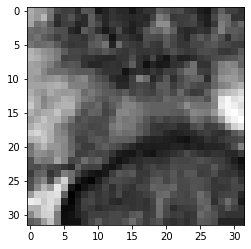

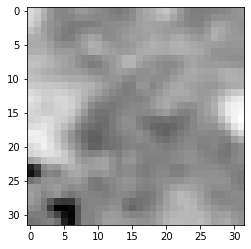

In [14]:
# random flipping, cropping and slightly shearing transformation to each T2 SPACE and ADC image pair to
# increase training data variety and model robustness

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://github.com/keras-team/keras/issues/3059

for num, count in patient_nums.items():
    dirname = 'data_organized/{}+{}'.format(num, count)
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.makedirs(dirname)

for lesion in lesions:
    t2_array = lesion.t2_image
    t2 = np.expand_dims(t2_array, axis=2)
    t2 = t2.reshape((1,) + t2.shape)

    adc_array = lesion.adc_image
    adc = np.expand_dims(adc_array, axis=2)
    adc = adc.reshape((1,) + adc.shape)

    datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
    
    plt.imshow(t2_array, cmap='gray')
    plt.show()
    plt.imshow(adc_array, cmap='gray')
    plt.show()
    
#     for x, val in zip(datagen.flow(t2, save_to_dir='data_augmented', save_prefix='t2', save_format='png'), range(6)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
#         pass
#     for x, val in zip(datagen.flow(adc, save_to_dir='data_augmented', save_prefix='adc', save_format='png'), range(6)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
#         pass
    
    break